In [1]:
!pip install datasets==2.16.0 transformers timm accelerate evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import evaluate
from datasets import load_dataset
import timm
from accelerate import Accelerator, notebook_launcher
from PIL import Image
import torchvision.transforms as T
from transformers.optimization import get_cosine_schedule_with_warmup

In [26]:
dataset = load_dataset("fuliucansheng/pascal_voc",'voc2007_main',trust_remote_code=True)

In [27]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2501
    })
    validation: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2510
    })
    test: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 4952
    })
})

In [28]:
classes = [
    "Aeroplane","Bicycle","Bird","Boat","Bottle",
    "Bus","Car","Cat","Chair","Cow","Diningtable",
    "Dog","Horse","Motorbike","Person",
    "Potted plant","Sheep","Sofa","Train","Tv/monitor"
]

In [29]:
label2id = {c:i for i,c in enumerate(classes)}
id2label = {i:c for c,i in label2id.items()}

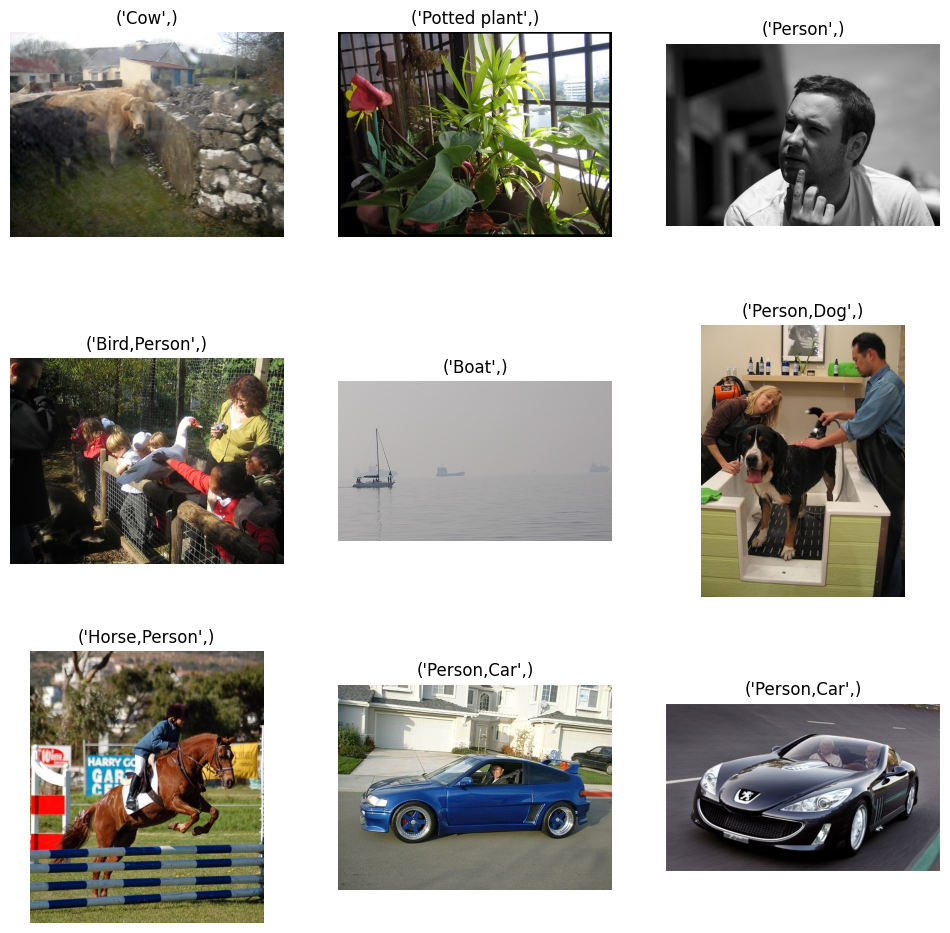

In [30]:
samples = dataset['train'].shuffle().select(np.arange(9))
fig = plt.figure(figsize=(12,12))
for i in range(9):
    img = samples[i]['image']
    labels = ','.join([id2label[cl] for cl in samples[i]['classes']]),
    fig.add_subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(labels)
    plt.axis('off')

In [31]:
# todo : label encoding, transforms for training and validation sets

labels = [samples[0]['classes'],[13]]
for label in labels:
    encoded_labels = nn.functional.one_hot(torch.tensor(label),num_classes=len(classes)).sum(0)
    print("labels:", labels)
    print("encoded_labels:", encoded_labels)


labels: [[9], [13]]
encoded_labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
labels: [[9], [13]]
encoded_labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


In [32]:
# transforms

img_size = (224,224)

train_tf = T.Compose([
    T.Resize(img_size),
    T.RandomRotation(30),
    T.RandomHorizontalFlip(),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5,0.5,0.5),
        std = (0.5,0.5,0.5)
    ),
])

test_tf = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5,0.5,0.5),
        std = (0.5,0.5,0.5)
    ),
])

In [33]:
def process_train(batch):
    processed = {}
    processed['pixel_values'] = [train_tf(x.convert('RGB')) for x in batch['image']]
    labels = batch['classes']
    enc_labels = []
    for label in labels:
        enc = nn.functional.one_hot(torch.tensor(label),num_classes=20).sum(dim=0)
        enc_labels.append(enc)
    processed['labels'] = torch.stack(enc_labels,dim=0)
    return processed
out = process_train(dataset['train'][:5])['labels']
[np.where(x == 1)[0] for x in (out.numpy() > 0.5)]

[array([6]), array([12, 14]), array([ 1, 14]), array([6]), array([ 0, 14])]

In [34]:
def process_val(batch):
    processed = {}
    processed['pixel_values'] = [test_tf(x.convert('RGB')) for x in batch['image']]
    labels = batch['classes']
    enc_labels = []
    for label in labels:
        enc = nn.functional.one_hot(torch.tensor(label),num_classes=20).sum(dim=0)
        enc_labels.append(enc)
    processed['labels'] = torch.stack(enc_labels,dim=0)
    return processed

In [35]:
train_dataset = dataset['train'].with_transform(process_train)
valid_dataset = dataset['validation'].with_transform(process_val)
test_dataset = dataset['test'].with_transform(process_val)

len(train_dataset), len(valid_dataset), len(test_dataset)

(2501, 2510, 4952)

In [36]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch]).float()
    }

In [37]:
def get_param_count(model):
    total_params = sum([p.numel() for p in model.parameters()])
    trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return total_params,trainable_params

In [41]:
def train(model_name,num_epochs,batch_size,lr):
    # Accelerator
    accelerator = Accelerator()

    # dataloaders - returns a batch
    train_dl = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers = 2,
        collate_fn=collate_fn
    )

    val_dl = torch.utils.data.DataLoader(
        valid_dataset,
        shuffle=False,
        batch_size=batch_size,
        num_workers=2,
        collate_fn=collate_fn
    )


    test_dl = torch.utils.data.DataLoader(
        test_dataset,
        shuffle=False,
        batch_size=batch_size,
        num_workers=2,
        collate_fn=collate_fn
    )

    # create the model
    model = timm.create_model(model_name,
                              pretrained=True,
                              num_classes=len(classes)
                             ).to(accelerator.device)

    total,trainable = get_param_count(model)
    accelerator.print("Total params",total)
    accelerator.print("Trainable params",trainable)

    # losses, optimizer and lr scheduling
    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.AdamW(model.parameters(),lr=lr)

    scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_training_steps=len(train_dl),
        num_warmup_steps=int(0.1 * len(train_dl)) # 10 % of total steps
    )

    model,optimizer,scheduler,train_dl,val_dl,test_dl = accelerator.prepare(
        model,optimizer,scheduler,train_dl,val_dl,test_dl
    )

    accelerator.print("Traning Started")

    for epoch in range(1,num_epochs+1):

        running_loss = 0.0

        model.train()

        train_metric = evaluate.load('roc_auc','multilabel')

        for batch in train_dl:

            logits = model(batch['pixel_values'])

            loss = criterion(logits,batch['labels'])

            accelerator.backward(loss)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            running_loss += loss.item()

            logits,labels = accelerator.gather_for_metrics(
                (logits,batch['labels'])
            )

            train_metric.add_batch(references=labels,prediction_scores=logits)

        train_loss = running_loss / len(train_dl)
        train_roc_auc = train_metric.compute(average='micro')['roc_auc']

        accelerator.print(f"\nEpoch : {epoch} | {train_loss = : .4f} | {train_roc_auc = :.4f}")

        model.eval()

        running_loss = 0.0
        val_metric = evaluate.load('roc_auc','multilabel')

        for batch in val_dl:

            with torch.no_grad():
                logits = model(batch['pixel_values'])

            loss = criterion(logits,batch['labels'])

            running_loss += loss.item()

            logits,labels = accelerator.gather_for_metrics(
                (logits,batch['labels'])
            )

            val_metric.add_batch(references=labels,prediction_scores=logits)

        val_loss = running_loss / len(val_dl)

        val_roc_auc = val_metric.compute(average='micro')['roc_auc']

        accelerator.print(f"{val_loss = :.4f} | {val_roc_auc = : .4f}")

        accelerator.save_model(model,f"./{model_name}-pascal")

    # test run

    test_metric = evaluate.load('roc_auc','multilabel')
    model.eval()
    for batch in test_dl:
        with torch.no_grad():
            logits = model(batch['pixel_values'])
        logits,labels = accelerator.gather_for_metrics(
            (logits,batch['labels'])
        )
        test_metric.add_batch(references=labels,prediction_scores=logits)

    test_roc_auc = test_metric.compute(average='micro')['roc_auc']

    accelerator.print(f"\n{test_roc_auc= :.4f}")


In [42]:
model_name = 'swin_s3_base_224'
notebook_launcher(train,(model_name,10,16,3e-4),num_processes=1)

Launching training on one GPU.
Total params 70372142
Trainable params 70372142
Traning Started

Epoch : 1 | train_loss =  0.2555 | train_roc_auc = 0.6854
val_loss = 0.2297 | val_roc_auc =  0.7122

Epoch : 2 | train_loss =  0.2310 | train_roc_auc = 0.7270
val_loss = 0.2299 | val_roc_auc =  0.7156

Epoch : 3 | train_loss =  0.2164 | train_roc_auc = 0.7829
val_loss = 0.1992 | val_roc_auc =  0.8291

Epoch : 4 | train_loss =  0.1763 | train_roc_auc = 0.8780
val_loss = 0.1329 | val_roc_auc =  0.9380

Epoch : 5 | train_loss =  0.0908 | train_roc_auc = 0.9708
val_loss = 0.0793 | val_roc_auc =  0.9781

Epoch : 6 | train_loss =  0.0918 | train_roc_auc = 0.9725
val_loss = 0.0996 | val_roc_auc =  0.9702

Epoch : 7 | train_loss =  0.0530 | train_roc_auc = 0.9914
val_loss = 0.0890 | val_roc_auc =  0.9758

Epoch : 8 | train_loss =  0.0695 | train_roc_auc = 0.9848
val_loss = 0.0798 | val_roc_auc =  0.9775

Epoch : 9 | train_loss =  0.0378 | train_roc_auc = 0.9959
val_loss = 0.0972 | val_roc_auc =  0.9

TypeError: ROCAUC._compute() got an unexpected keyword argument 'avg'

In [57]:
from safetensors.torch import load_model
model = timm.create_model(model_name,pretrained=True,num_classes=20).to('cuda')

In [58]:
load_model(model,f'./{model_name}-pascal/model.safetensors')

(set(), [])

In [60]:
test_metric = evaluate.load('roc_auc','multilabel')
test_dl = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=16,
    num_workers=2,
    collate_fn=collate_fn
)
model.eval()
for batch in test_dl:
    with torch.no_grad():
        logits = model(batch['pixel_values'].to('cuda'))
    test_metric.add_batch(references=batch['labels'].to('cuda'),prediction_scores=logits)

test_roc_auc = test_metric.compute(average='micro')['roc_auc']
print("Test roc_auc :",test_roc_auc)

Test roc_auc : 0.9804633456887992


In [55]:
model_cfg = dict(label_names=classes)
timm.models.push_to_hf_hub(model, 'swin_s3_base_224-finetuned-pascal', model_config=model_cfg)

pytorch_model.bin:   0%|          | 0.00/282M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/OmAlve/swin_s3_base_224-finetuned-pascal/commit/c0ca17f816247e32571bf3700a06de9ecc9e7bd1', commit_message='Add model', commit_description='', oid='c0ca17f816247e32571bf3700a06de9ecc9e7bd1', pr_url=None, pr_revision=None, pr_num=None)

In [53]:
from huggingface_hub import login

In [54]:
login()

In [56]:
from huggingface_hub import push_to_hub

model_name = "Swin_s3_base_224-finetuned-pascal"
repo_name = "OmAlve/Swin_s3_base_224-finetuned-pascal"

model.push_to_hub(repo_name, use_safetensors=True, model_name=model_name)

ImportError: cannot import name 'push_to_hub' from 'huggingface_hub' (/usr/local/lib/python3.10/dist-packages/huggingface_hub/__init__.py)

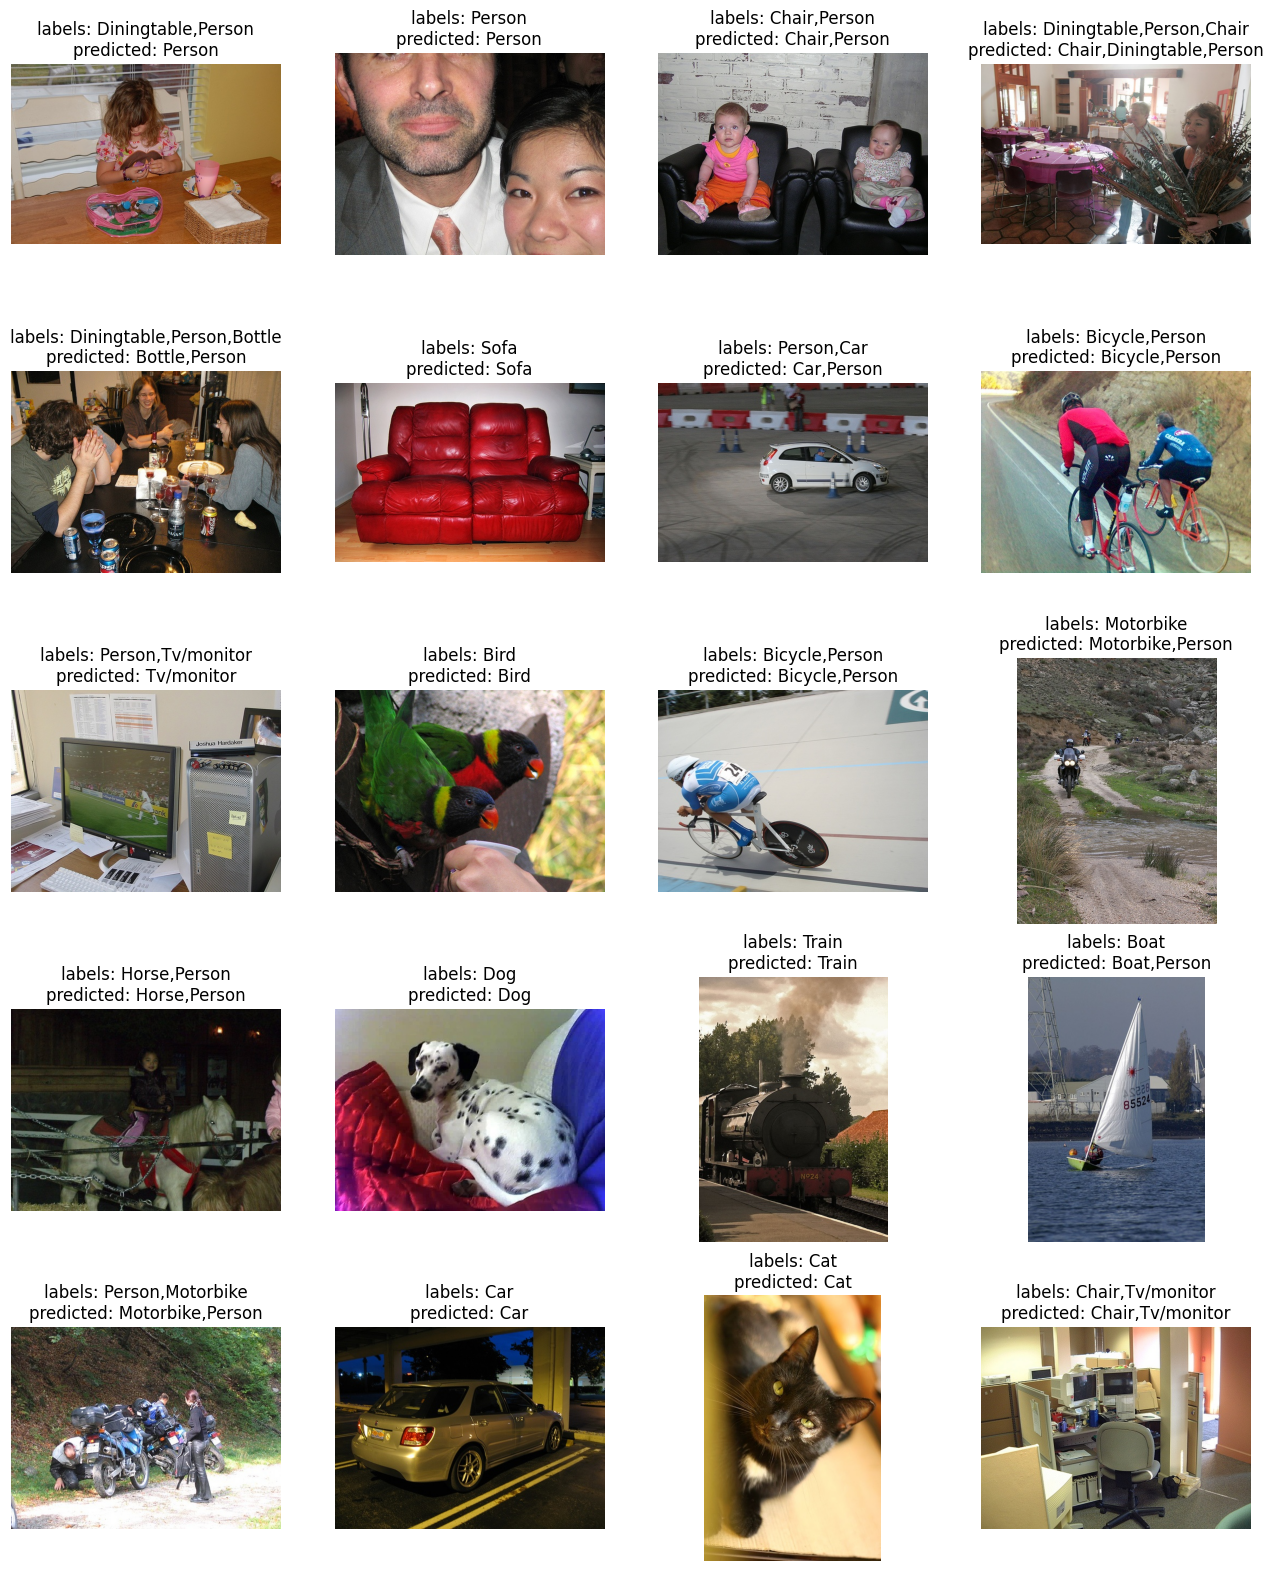

In [93]:
def process_test(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]

    batch['pixel_values'] = [test_tf(x.convert('RGB')) for x in batch['image']]
    labels = batch['classes']
    enc_labels = []
    for label in labels:
        enc = nn.functional.one_hot(torch.tensor(label),num_classes=20).sum(dim=0)
        enc_labels.append(enc)
    batch['labels'] = torch.stack(enc_labels,dim=0)
    return batch

def show_predictions(rows=2,cols=4):
    model.eval()
    samples = test_dataset.shuffle().select(np.arange(rows*cols))
    fig = plt.figure(figsize=(cols*4,rows*4))

    for i in range(rows*cols):
        img = samples[i]['image']
        inputs = samples[i]['pixel_values'].unsqueeze(0).to('cuda')
        labels = samples[i]['classes']
        labels = ','.join([id2label[lb] for lb in labels])

        with torch.no_grad():
            logits = model(inputs)

        # apply sigmoid activation to convert logits to probabilities
        # getting labels with confidence threshold of 0.5
        predictions = logits.sigmoid() > 0.5

        # converting one-hot encoded predictions back to list of labels
        predictions = predictions.cpu().float().numpy().flatten() # convert boolean predictions to float
        pred_labels = np.where(predictions==1)[0] # find indices where prediction is 1
        pred_labels = ','.join([id2label[label] for label in pred_labels]) # converting integer labels to string

        label = f"labels: {labels}\npredicted: {pred_labels}"
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_predictions(rows=5,cols=4)

In [84]:
test_dataset = dataset['test'].with_transform(process_test)

In [85]:
samples = test_dataset.shuffle().select([1])

In [86]:
samples[0]

{'id': 492,
 'image': <PIL.Image.Image image mode=RGB size=375x500>,
 'height': 500,
 'width': 375,
 'classes': [15],
 'objects': {'bboxes': [[36.0, 70.0, 288.0, 486.0]],
  'classes': [15],
  'difficult': [0]},
 'pixel_values': tensor([[[-0.5294, -0.5608, -0.5451,  ..., -0.7255, -0.7333, -0.7333],
          [-0.5216, -0.5451, -0.5373,  ..., -0.6941, -0.7098, -0.7098],
          [-0.5294, -0.5137, -0.5373,  ..., -0.6784, -0.6863, -0.6941],
          ...,
          [ 0.4118,  0.4039,  0.3961,  ...,  0.2078,  0.2314,  0.2627],
          [ 0.4118,  0.4118,  0.3961,  ...,  0.2314,  0.2078,  0.2706],
          [ 0.4039,  0.4039,  0.3882,  ...,  0.2314,  0.2235,  0.2549]],
 
         [[-0.8980, -0.9059, -0.9216,  ..., -0.9529, -0.9294, -0.9216],
          [-0.8980, -0.9216, -0.9137,  ..., -0.9451, -0.9451, -0.9294],
          [-0.9137, -0.9059, -0.9059,  ..., -0.9451, -0.9529, -0.9451],
          ...,
          [ 0.4824,  0.4745,  0.4745,  ...,  0.2784,  0.3020,  0.3255],
          [ 0.4824, 